<h1>MIMIC Treatment Disparities, Stratified by Mistrust</h1>
The code can stand to be cleaned up to mirror the tidy-ness of race_mimic_aggressive.ipynb, but it generates the figures from the poster.

In [8]:
import psycopg2
import tqdm

# create a database connection
sqluser = 'wboag'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, host="/var/run/postgresql")

In [9]:
# Preprocessing / Normalization

def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'WHITE' in race:
        return 'White'
    return 'Other'

def normalize_discharge(disch):
    if disch.startswith('HOSPICE'):
        return 'Hospice'
    if disch == 'DEAD/EXPIRED':
        return 'Deceased'
    if disch.startswith('SNF'):
        return 'Skilled Nursing Facility'
    return 'other'

In [23]:
# Query for data

import pandas as pd
import time

print time.strftime("%Y-%m-%d %H:%M:%s")

# static demographic info
demographics_query = 'SELECT distinct subject_id,hadm_id,gender,ethnicity,age FROM mimiciii.icustay_detail;' 
demographics = pd.read_sql_query(demographics_query, con)

demographics['ethnicity'] = demographics['ethnicity'].apply(normalize_race)
demographics = demographics.rename(columns={'ethnicity':'race'})

def normalize_age(age):
    return min(age, 90)
demographics['age'] = demographics['age'].apply(normalize_age)


# admissions info
discharge_query = '''SELECT distinct subject_id,hadm_id,ethnicity,discharge_location,admittime,dischtime
  FROM mimiciii.admissions;'''
discharge = pd.read_sql_query(discharge_query, con)

discharge['discharge_location'] = discharge['discharge_location'].apply(normalize_discharge)

discharge['ethnicity'] = discharge['ethnicity'].apply(normalize_race)
discharge = discharge.rename(columns={'ethnicity':'race'})


print time.strftime("%Y-%m-%d %H:%M:%s")

discharge.head()

2019-01-04 23:00:1546660801
2019-01-04 23:00:1546660802


In [25]:
# EOL Cohort
import numpy as np

print time.strftime("%Y-%m-%d %H:%M:%s")

# query for discharge info
mortality_query = 'SELECT distinct subject_id,dod FROM mimiciii.patients'
mortality = pd.read_sql_query(mortality_query, con)

# patients who died or went to hospice
#eol_locations = {'Hospice', 'Deceased'}
eol_locations = {'Hospice', 'Deceased', 'Skilled Nursing Facility'}
disch = discharge.loc[discharge['discharge_location'].isin(eol_locations)]

expired = pd.merge(discharge,mortality, on=['subject_id'])
expired['mort'] = expired['dod'] - expired['dischtime']
six_months = expired.loc[expired['mort']<=pd.Timedelta(days=360)]
in_hosp = expired.loc[expired['mort']<=pd.Timedelta(days=0)]
zero_to_six = six_months.loc[~six_months['hadm_id'].isin(in_hosp)]
one_week = expired.loc[expired['mort']<=pd.Timedelta(days=7)]

#ids =  set(six_months.hadm_id.values) | set(disch)
#ids =  set(six_months.hadm_id.values) | set(disch)
#ids =  (set(six_months.hadm_id.values) & set(disch))
#ids =  set(six_months.hadm_id.values) 
#ids =  set(in_hosp.hadm_id.values) | set(disch.hadm_id.values)
ids =  set(disch.hadm_id.values)
#ids =  set(zero_to_six.hadm_id.values) 
#ids =  set(one_week.hadm_id.values) 
#ids =  (set(zero_to_six.hadm_id.values)) & set(disch.hadm_id.values)
#ids =  (set(zero_to_six.hadm_id.values)) & set(disch.hadm_id.values)
#ids =  (set(zero_to_six.hadm_id.values))
#ids =  set(disch.hadm_id.values)
#ids =  set(disch.hadm_id.values) & set(six_months.hadm_id.values)
#eol_cohort_initial = six_months
eol_cohort_initial = discharge.loc[discharge.hadm_id.isin(ids)]

inds_at_least_6hrs = eol_cohort_initial['dischtime'] - eol_cohort_initial['admittime'] > pd.Timedelta(days=1)
eol_cohort_initial = eol_cohort_initial.loc[inds_at_least_6hrs]

# add demographics info
eol_cohort = pd.merge(eol_cohort_initial, demographics, on=['hadm_id','race'])
#eol_cohort = eol_cohort.rename(columns={'ethnicity':'race'})

# normalize columns of data
#eol_cohort['discharge_location'] = eol_cohort['discharge_location'].apply(normalize_discharge)


# make sure each hadm_id has only died once
print 'eol subjects:', len(eol_cohort)
print 'eol subjects:', len(set(eol_cohort['hadm_id'].values))
assert len(eol_cohort) == len(set(eol_cohort['hadm_id'].values))

print time.strftime("%Y-%m-%d %H:%M:%s")

2019-01-04 23:01:1546660869
eol subjects: 12892
eol subjects: 12892
2019-01-04 23:01:1546660869


In [26]:
# Useful processing tools for treatment duration data

from collections import defaultdict

def find(groups, it):
    for i,group in enumerate(groups):
        if it in group:
            return i

def transitive_closure(items, merge):
    groups = [ [it] for it in items ]
    for a,b in merge:
        # make sure a and b are in the same group
        group_a = find(groups, a)
        group_b = find(groups, b)
        if group_a < group_b:
            group_ab = groups[group_a] + groups[group_b]
            del groups[group_b]
            del groups[group_a]
            groups.append(group_ab)
        elif group_a > group_b:
            group_ab = groups[group_a] + groups[group_b]
            del groups[group_a]
            del groups[group_b]
            groups.append(group_ab)
        else:
            # already same group
            pass
    return groups

In [27]:
# Mechanical Ventilation

import tqdm

eol_hadmids = map(str,set(eol_cohort['hadm_id'].values))

query = \
"""
select i.hadm_id, v.starttime, v.endtime
FROM mimiciii.icustay_detail i
INNER JOIN mimiciii.ventdurations v ON i.icustay_id = v.icustay_id
where i.hadm_id in (%s)
and v.starttime between intime and outtime
and v.endtime between intime and outtime;
""" % ','.join(eol_hadmids)

vent_data = pd.read_sql_query(query, con)


duration_aggregate = 'sum_spans'
vent_spans = defaultdict(list)
for hadm_id,rows in tqdm.tqdm(vent_data.groupby('hadm_id')):
    rows =  rows.sort_values('starttime')
    
    if duration_aggregate == 'max-min':
        span = rows.iloc[-1].endtime - rows.iloc[0].starttime
        assert span > pd.Timedelta(days=0)
        vent_spans[hadm_id].append(span)   
    elif duration_aggregate == 'sum_spans':
        merge = []
        for i in range(len(rows)-1):
            if rows.iloc[i+1].starttime - rows.iloc[i].endtime <= pd.Timedelta(hours=10):
                merge.append( (i,i+1) )

        for group in transitive_closure(range(len(rows)), merge):
            lo = min(group)
            hi = max(group)
            span = rows.iloc[hi].endtime - rows.iloc[lo].starttime
            assert span > pd.Timedelta(days=0)
            vent_spans[hadm_id].append(span)
    else:
        raise Exception('dunno!')

vent_quantity = { hadm_id:sum([ts.total_seconds()/60. for ts in timestamps]) for hadm_id,timestamps in vent_spans.items() }
#vent_quantity = { hadm_id:timestamps[0].total_seconds()/60. for hadm_id,timestamps in vent_spans.items() }
#vent_quantity = { hadm_id:timestamps[-1].total_seconds()/60. for hadm_id,timestamps in vent_spans.items() }

100%|██████████| 6304/6304 [00:09<00:00, 655.84it/s]


In [28]:
# Vasopressors

import tqdm

# Start merging all other interventions
table_names  = ['vasopressordurations']
column_names = ['vaso'                ]

eol_hadmids = map(str,set(eol_cohort['hadm_id'].values))

vaso_quantities = defaultdict(dict)
for t, c in zip(table_names, column_names):
    print (t, c)
    # TOTAL VASOPRESSOR DATA
    query = """
    select i.hadm_id, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.%s v ON i.icustay_id = v.icustay_id
    where v.starttime between intime and outtime
    and   v.endtime   between intime and outtime
    and i.hadm_id in (%s);
    """ % (t, ','.join(eol_hadmids))
    vaso_data = pd.read_sql_query(query,con)
    print (vaso_data.head())

    #print time.strftime("%Y-%m-%d %H:%M:%s")

    duration_aggregate = 'sum_spans'
    vaso_spans = defaultdict(list)
    for hadm_id,rows in tqdm.tqdm(vaso_data.groupby('hadm_id')):
        rows =  rows.sort_values('starttime')

        if duration_aggregate == 'max-min':
            span = rows.iloc[-1].endtime - rows.iloc[0].starttime
            assert span >= pd.Timedelta(days=0)
            vaso_spans[hadm_id].append(span)   
        elif duration_aggregate == 'sum_spans':
            merge = []
            for i in range(len(rows)-1):
                if rows.iloc[i+1].starttime - rows.iloc[i].endtime <= pd.Timedelta(hours=10):
                    merge.append( (i,i+1) )

            for group in transitive_closure(range(len(rows)), merge):
                lo = min(group)
                hi = max(group)
                span = rows.iloc[hi].endtime - rows.iloc[lo].starttime
                assert span >= pd.Timedelta(days=0)
                vaso_spans[hadm_id].append(span)
        else:
            raise Exception('dunno!')
            
    vaso_quantities[c] = { hadm_id:sum([ts.total_seconds()/60. for ts in timestamps]) for hadm_id,timestamps in vaso_spans.items() }
    #vaso_quantities[c] = { hadm_id:timestamps[0].total_seconds()/60. + 5 for hadm_id,timestamps in vaso_spans.items() }
    #vaso_quantities[c] = { hadm_id:timestamps[-1].total_seconds()/60. for hadm_id,timestamps in vaso_spans.items() }



('vasopressordurations', 'vaso')


  0%|          | 0/5802 [00:00<?, ?it/s]

   hadm_id           starttime             endtime
0   165426 2150-11-13 15:00:00 2150-11-15 08:00:00
1   198650 2198-08-10 18:30:00 2198-08-10 19:45:00
2   198650 2198-08-10 19:57:00 2198-08-10 20:32:00
3   198650 2198-08-10 20:50:00 2198-08-11 01:30:00
4   198650 2198-08-11 02:20:00 2198-08-11 03:00:00


100%|██████████| 5802/5802 [00:10<00:00, 575.24it/s]


In [29]:
# load oasis severity scores
oasis_query = 'select hadm_id,max(oasis) as oasis from mimiciii.oasis group by hadm_id'
oasis_df = pd.read_sql_query(oasis_query, con)
severities = dict(oasis_df[['hadm_id','oasis']].values)
print len(severities)

57786


<h1>Racial Disparities in Mistrust Metrics</h1>

2019-01-05 00:01:1546664508
2019-01-05 00:01:1546664508
	white:    9449 0.031553313587987214
	black: 1148 0.10598605731725357
	p-value: 0.010246258743310718


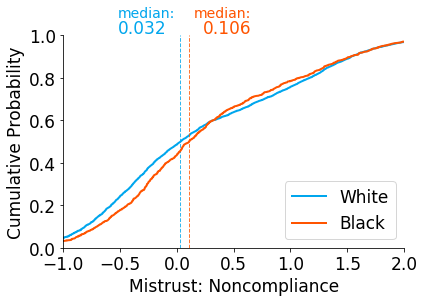

In [38]:
import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu

# Mistrust scores
print time.strftime("%Y-%m-%d %H:%M:%s")
import cPickle as pickle
with open('../data/mistrust_noncompliant.pkl', 'rb') as f:
    scores = pickle.load(f)
vals = np.array(scores.values())
mu = vals.mean()
std = vals.std()
scores = {hadm_id:(s-mu)/std for hadm_id,s in scores.items()}
print time.strftime("%Y-%m-%d %H:%M:%s")

# Get b/w cohorts
white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(scores.keys())
black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(scores.keys())
#white_ids = set(demographics.loc[demographics['race']=='White'].hadm_id.values) & set(scores.keys())
#black_ids = set(demographics.loc[demographics['race']=='Black'].hadm_id.values) & set(scores.keys())

white_mistrust = [scores[hadm_id] for hadm_id in white_ids]
black_mistrust = [scores[hadm_id] for hadm_id in black_ids]


def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)/2]

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

colors = ['#00A6ED', '#FF5400']
i = 0

fig = pl.figure()

w_median = list_median(white_mistrust)
b_median = list_median(black_mistrust)
larger_median = max(w_median, b_median)

mistrusts = {'White':white_mistrust, 'Black':black_mistrust}

for demographic in ['White', 'Black']:
    vals = list(mistrusts[demographic])
    #print(len(vals))
    #print (np.sort(vals)[int(len(vals)/2)])
    pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
    pl.xlim((-1,2))
    pl.ylim((0,1.0))

    median = np.sort(vals)[int(len(vals)/2)]
    pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
    p = 0.55
    if median == larger_median:
        h = 'right'
    else:
        p = -p
        h = 'left'
    #h = 'center'
    pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
    pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=('%.3f' % median), fontsize=17, color=colors[i])

    i += 1

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)    
pl.yticks(fontsize=17)    
pl.xticks(fontsize=17) 

pl.legend(loc=4, fontsize=17)
pl.ylabel("Cumulative Probability", fontsize=17)
pl.xlabel("Mistrust: Noncompliance", fontsize=17)

pl.tight_layout()
pl.savefig('../images/chapter4/mistrust_noncompliant_mimic.png')

p1 = list(white_mistrust)
p2 = list(black_mistrust)
w = mannwhitneyu(p1, p2)
print '\twhite:   ', len(p1), w_median
print '\tblack:', len(p2), b_median
print '\tp-value:', w.pvalue

pl.show()

2019-01-05 00:01:1546664512
2019-01-05 00:01:1546664513
	white:    9449 -0.19758911580400382
	black: 1148 -0.19747602081406612
	p-value: 0.07308531816558056


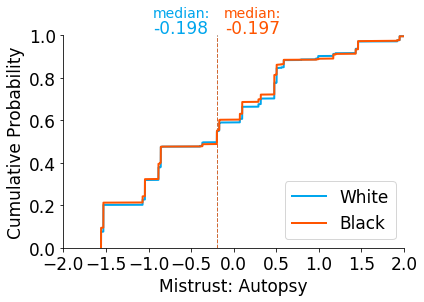

In [39]:
import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu
import random

# Mistrust scores
print time.strftime("%Y-%m-%d %H:%M:%s")
import cPickle as pickle
with open('../data/mistrust_autopsy.pkl', 'rb') as f:
    scores = pickle.load(f)
vals = np.array(scores.values())
mu = vals.mean()
std = vals.std()
scores = {hadm_id:(s-mu)/std for hadm_id,s in scores.items()}
print time.strftime("%Y-%m-%d %H:%M:%s")

# Get b/w cohorts
white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(scores.keys())
black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(scores.keys())
#white_ids = set(demographics.loc[demographics['race']=='White'].hadm_id.values) & set(scores.keys())
#black_ids = set(demographics.loc[demographics['race']=='Black'].hadm_id.values) & set(scores.keys())


white_mistrust = [scores[hadm_id]+random.random()/1000 for hadm_id in white_ids]
black_mistrust = [scores[hadm_id]+random.random()/1000 for hadm_id in black_ids]


def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)/2]

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

colors = ['#00A6ED', '#FF5400']
i = 0

fig = pl.figure()

w_median = list_median(white_mistrust)
b_median = list_median(black_mistrust)
larger_median = max(w_median, b_median)

mistrusts = {'White':white_mistrust, 'Black':black_mistrust}

for demographic in ['White', 'Black']:
    vals = list(mistrusts[demographic])
    #print(len(vals))
    #print (np.sort(vals)[int(len(vals)/2)])
    pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
    pl.xlim((-2,2))
    pl.ylim((0,1.0))

    median = np.sort(vals)[int(len(vals)/2)]
    pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
    p = 0.75
    if median == larger_median:
        h = 'right'
    else:
        p = -p
        h = 'left'
    #h = 'center'
    pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
    pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=('%.3f' % median), fontsize=17, color=colors[i])

    i += 1

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)    
pl.yticks(fontsize=17)    
pl.xticks(fontsize=17) 

plt.legend(loc=4, fontsize=17)
pl.ylabel("Cumulative Probability", fontsize=17)
pl.xlabel("Mistrust: Autopsy", fontsize=17)

pl.tight_layout()
pl.savefig('../images/chapter4/mistrust_autopsy_mimic.png')

p1 = list(white_mistrust)
p2 = list(black_mistrust)
w = mannwhitneyu(p1, p2)
print '\twhite:   ', len(p1), w_median
print '\tblack:', len(p2), b_median
print '\tp-value:', w.pvalue

pl.show()

2019-01-05 00:01:1546664514
2019-01-05 00:01:1546664515
-0.55
0.55
	white:    9230 0.15785717009005262
	black: 1131 0.2231712358348549
	p-value: 0.0069122070324536804


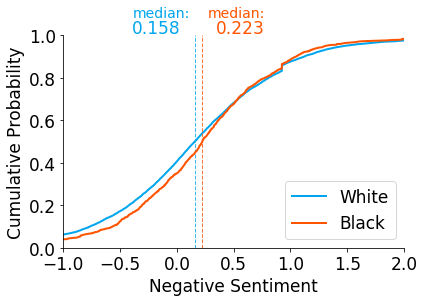

In [40]:
import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu
import random

# Mistrust scores
print time.strftime("%Y-%m-%d %H:%M:%s")
import cPickle as pickle
with open('../data/neg_sentiment.pkl', 'rb') as f:
    scores = pickle.load(f)
vals = np.array(scores.values())
mu = vals.mean()
std = vals.std()
scores = {hadm_id:(s-mu)/std for hadm_id,s in scores.items()}
print time.strftime("%Y-%m-%d %H:%M:%s")

# Get b/w cohorts
white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(scores.keys())
black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(scores.keys())
#white_ids = set(demographics.loc[demographics['race']=='White'].hadm_id.values) & set(scores.keys())
#black_ids = set(demographics.loc[demographics['race']=='Black'].hadm_id.values) & set(scores.keys())

white_mistrust = [scores[hadm_id] for hadm_id in white_ids]
black_mistrust = [scores[hadm_id] for hadm_id in black_ids]


def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)/2]

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

colors = ['#00A6ED', '#FF5400']
i = 0

fig = pl.figure()

w_median = list_median(white_mistrust) 
b_median = list_median(black_mistrust)
larger_median = max(w_median, b_median)

mistrusts = {'White':white_mistrust, 'Black':black_mistrust}

for demographic in ['White', 'Black']:
    vals = list(mistrusts[demographic])
    #print(len(vals))
    #print (np.sort(vals)[int(len(vals)/2)])
    plt.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
    plt.xlim((-1,2))
    plt.ylim((0,1.0))

    median = np.sort(vals)[int(len(vals)/2)]
    plt.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
    p = 0.55
    if median == larger_median:
        h = 'right'
    else:
        p = -p
        h = 'left'
    #h = 'center'
    print p
    plt.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
    plt.text(x=median+p, y=1.01 , horizontalalignment=h, s=('%.3f' % median), fontsize=17, color=colors[i])

    i += 1

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)    
plt.yticks(fontsize=17)    
plt.xticks(fontsize=17) 

plt.legend(loc=4, fontsize=17)
plt.ylabel("Cumulative Probability", fontsize=17)
plt.xlabel("Negative Sentiment", fontsize=17)

plt.tight_layout()
plt.savefig('../images/chapter4/neg_sentiment_mimic.png')

p1 = list(white_mistrust)
p2 = list(black_mistrust)
w = mannwhitneyu(p1, p2)
print '\twhite:   ', len(p1), w_median
print '\tblack:', len(p2), b_median
print '\tp-value:', w.pvalue

plt.show()

<h1>Trust-based Treatment Disparities</h1>

2019-01-04 23:59:1546664399
2019-01-05 00:00:1546664400


/scratch/wboag/2019/cleanup/venv_2/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


mistrust_noncompliant
vent
	trust:    4537 2460.0
	mistrust: 484 4380.0
	p-value: 6.2447213642492726e-12


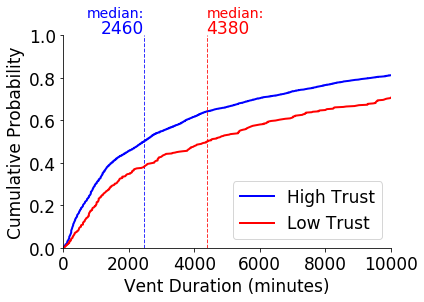

mistrust_noncompliant
vaso
	trust:    4189 1780.0
	mistrust: 421 2150.0
	p-value: 0.01474176163927212


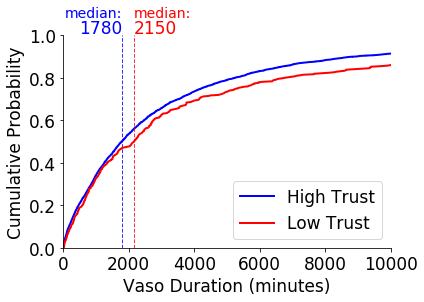

100%|██████████| 2/2 [00:00<00:00, 140.17it/s]

vent 35 43 1673 1674 1674
vaso 34 42 1536 1537 1537
vent
	low
		High Trust 1571
		Low Trust 147
	medium
		High Trust 1632
		Low Trust 186
	high
		High Trust 1334
		Low Trust 151
vaso
	low
		High Trust 1437
		Low Trust 142
	medium
		High Trust 1442
		Low Trust 153
	high
		High Trust 1310
		Low Trust 126
vent
	vent low
		High Trust 1571
		Low Trust 147
vent low
	trust:    1571 1480.0
	mistrust: 147 4065.0
	p-value: 6.390122572468688e-07
	vent medium
		High Trust 1632


		Low Trust 186
vent medium
	trust:    1632 2665.0
	mistrust: 186 3900.0
	p-value: 8.012005156337581e-05
	vent high
		High Trust 1334
		Low Trust 151
vent high
	trust:    1334 3360.0
	mistrust: 151 5100.0
	p-value: 0.005714006363364345


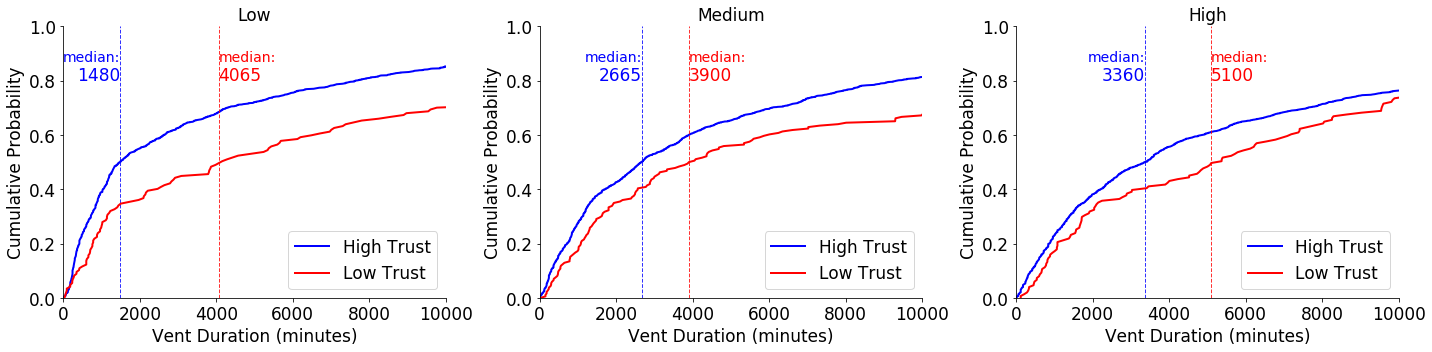

vaso
	vaso low
		High Trust 1437
		Low Trust 142
vaso low
	trust:    1437 1341.0
	mistrust: 142 1649.0
	p-value: 0.05193590454208406
	vaso medium
		High Trust 1442
		Low Trust 153
vaso medium
	trust:    1442 1766.0
	mistrust: 153 2230.0
	p-value: 0.16207089811566378
	vaso high
		High Trust 1310
		Low Trust 126
vaso high
	trust:    1310 2280.0
	mistrust: 126 2725.0
	p-value: 0.05786924156313259


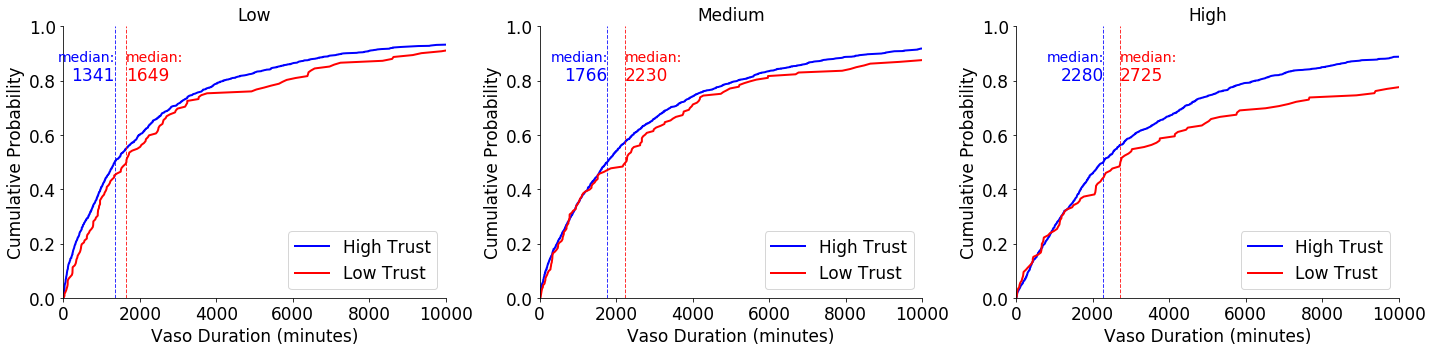

In [35]:
# Mistrust scores
print time.strftime("%Y-%m-%d %H:%M:%s")
import cPickle as pickle

mistrust_str = 'mistrust_noncompliant'
#mistrust_str = 'mistrust_autopsy'
#mistrust_str = 'neg_sentiment'

with open('../data/%s.pkl' % mistrust_str, 'rb') as f:
    trust_scores = pickle.load(f)
print time.strftime("%Y-%m-%d %H:%M:%s")


%matplotlib inline

import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu


# Put each treatment into the dictionary
T = {}
for vaso,vaso_quantity in vaso_quantities.items(): 
    # Get size of b/w cohorts
    vaso_white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(trust_scores.keys()) & set(vaso_quantity.keys())
    vaso_black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(trust_scores.keys()) & set(vaso_quantity.keys())

    # Stratify into high/low trust
    vaso_cohort = (vaso_white_ids | vaso_black_ids)  & set(vaso_quantity.keys())
    vaso_cohort_ids = sorted([(hadm_id,trust_scores[hadm_id]) for hadm_id in vaso_cohort], key=lambda t:t[1])
    vaso_trust_ids    = [hadm_id for hadm_id,score in vaso_cohort_ids[:len(vaso_white_ids) ]]
    vaso_mistrust_ids = [hadm_id for hadm_id,score in vaso_cohort_ids[ len(vaso_white_ids):]]

    trust_eol_vaso    = {hadm_id:vaso_quantity[hadm_id] for hadm_id in vaso_trust_ids    if hadm_id in vaso_quantity}
    mistrust_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in vaso_mistrust_ids if hadm_id in vaso_quantity}
    T[vaso] = {'Low Trust':mistrust_eol_vaso, 'High Trust':trust_eol_vaso}

# Get size of b/w cohorts
vent_white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(trust_scores.keys()) & set(vent_quantity.keys())
vent_black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(trust_scores.keys()) & set(vent_quantity.keys())

# Stratify into high/low trust
vent_cohort = (vent_white_ids | vent_black_ids)
vent_cohort_ids = sorted([(hadm_id,trust_scores[hadm_id]) for hadm_id in vent_cohort], key=lambda t:t[1])
vent_trust_ids    = [hadm_id for hadm_id,score in vent_cohort_ids[:len(vent_white_ids) ]]
vent_mistrust_ids = [hadm_id for hadm_id,score in vent_cohort_ids[ len(vent_white_ids):]]

trust_eol_vent    = {hadm_id:vent_quantity[hadm_id] for hadm_id in vent_trust_ids   }
mistrust_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in vent_mistrust_ids}
T['vent'] =  {'Low Trust':mistrust_eol_vent, 'High Trust':trust_eol_vent}



import pylab as plt

def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)/2]

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

colors = ['#0000FF', '#FF0000']
for treatment in T.keys():
    i = 0
    
    fig = pl.figure(treatment)

    t_median = list_median(T[treatment]['High Trust'].values())
    m_median = list_median(T[treatment][ 'Low Trust'].values())
    larger_median = min(t_median, m_median)
        
    for demographic in ['High Trust', 'Low Trust']:
        vals = list(T[treatment][demographic].values())
        #print(len(vals))
        #print (np.sort(vals)[int(len(vals)/2)])
        plt.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
        plt.xlim((0,10000))
        plt.ylim((0,1.0))

        median = np.sort(vals)[int(len(vals)/2)]
        plt.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
        if median == larger_median:
            p = 10
            h = 'right'
        else:
            p = -10
            h = 'left'
        #h = 'center'
        plt.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
        plt.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        i += 1

    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    #ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    #ax.spines["left"].set_visible(False)    
    plt.yticks(fontsize=17)    
    plt.xticks(fontsize=17) 

    plt.legend(loc=4, fontsize=17)
    plt.ylabel("Cumulative Probability", fontsize=17)
    plt.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

    plt.tight_layout()
    plt.savefig('../images/chapter5/%s_mimic_%s.png' % (mistrust_str,treatment))

    p1 = list(T[treatment]['High Trust'].values())
    p2 = list(T[treatment][ 'Low Trust'].values())
    w = mannwhitneyu(p1, p2)
    print mistrust_str
    print treatment
    print '\ttrust:   ', len(p1), t_median
    print '\tmistrust:', len(p2), m_median
    print '\tp-value:', w.pvalue
    
    plt.show()
    
    
    
treatment_severity_populations = {treatment:[] for treatment in T.keys()}
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            severity = severities[hadm_id]
            treatment_severity_populations[treatment].append(severity)

treatment_severity_thresholds = {}
for treatment,scores in treatment_severity_populations.items():
    vals = sorted(scores)
    n = len(vals)
    print treatment, vals[n/3], vals[2*n/3], len(vals[:n/3]), len(vals[n/3:2*n/3]), len(vals[2*n/3:])
    treatment_severity_thresholds[treatment] = vals[n/3], vals[2*n/3]
    
    
    
    
import tqdm

# partition by treatment
T_risk = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            # acuity bin
            severity = severities[hadm_id]
            if severities[hadm_id] <= treatment_severity_thresholds[treatment][0]:
                acuity = 'low'
            elif severities[hadm_id] <= treatment_severity_thresholds[treatment][1]:
                acuity = 'medium'
            else:
                acuity = 'high'

            T_risk[treatment][acuity][race].append(amount)

for treatment,cohorts in T_risk.items():
    print treatment
    for severity in ['low', 'medium', 'high']:
        print '\t', severity
        cohort = cohorts[severity]
        for race,ids in cohort.items():
            print '\t\t', race, len(ids)
            
            

for treatment in T_risk.keys():
    #if 'vaso' not in treatment: continue
    print treatment
    fig = pl.figure(treatment, (20,5))

    for i,severity in enumerate(['low','medium','high']):
        #fig = pl.figure('-'.join([treatment,severity]))
        ind = 131 + i
        ax = fig.add_subplot(ind)
                
        print '\t', treatment, severity

        t_median = list_median(T_risk[treatment][severity]['High Trust'])
        m_median = list_median(T_risk[treatment][severity][ 'Low Trust'])
        larger_median = min(t_median, m_median)
        
        for j,demographic in enumerate(['High Trust', 'Low Trust']):
            vals = list(T_risk[treatment][severity][demographic])
            #print(len(vals))
            #print (np.sort(vals)[int(len(vals)/2)])
            ax.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[j], label = demographic, lw=2)
            pl.xlim((0,10000))
            pl.ylim((0,1.0))

            print '\t\t', demographic, len(vals)
            median = np.sort(vals)[int(len(vals)/2)]
            ax.axvline(x=median, linestyle="--", lw=1, color=colors[j], alpha=0.8) 
            if median == larger_median:
                p = 10
                h = 'right'
            else:
                p = -10
                h = 'left'
            #h = 'center'
            ax.text(x=median+p, y=0.87, horizontalalignment=h, s="median:", fontsize=14, color=colors[j])
            ax.text(x=median+p, y=0.8 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[j])

        #ax = pl.subplot(111)    
        ax.spines["top"].set_visible(False)    
        #ax.spines["bottom"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        #ax.spines["left"].set_visible(False)    
        pl.yticks(fontsize=17)    
        pl.xticks(fontsize=17) 

        pl.title(captialize(severity), fontsize=17)
        pl.legend(loc=4, fontsize=17)
        pl.ylabel("Cumulative Probability", fontsize=17)
        pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

        pl.tight_layout()

        p1 = list(T_risk[treatment][severity]['High Trust'])
        p2 = list(T_risk[treatment][severity][ 'Low Trust'])
        w = mannwhitneyu(p1, p2)
        print treatment, severity
        print '\ttrust:   ', len(p1), t_median
        print '\tmistrust:', len(p2), m_median
        print '\tp-value:', w.pvalue
    pl.savefig('../images/chapter5/%s_mimic_%s_severity.png' % (mistrust_str,treatment))
    pl.show()
    #break
    #exit()


2019-01-05 00:00:1546664402
2019-01-05 00:00:1546664402
mistrust_autopsy
vent
	trust:    4537 2376.0
	mistrust: 484 5228.0
	p-value: 1.1538310141917728e-23


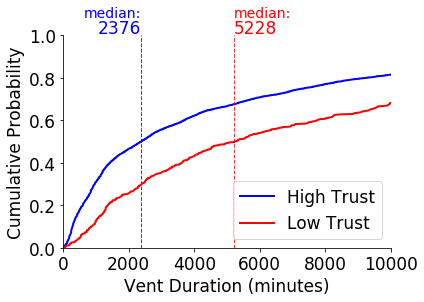

mistrust_autopsy
vaso
	trust:    4189 1740.0
	mistrust: 421 2490.0
	p-value: 1.8438093308424784e-07


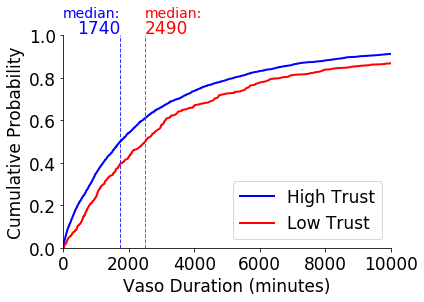

  0%|          | 0/2 [00:00<?, ?it/s]

vent 35 43 1673 1674 1674
vaso 34 42 1536 1537 1537


100%|██████████| 2/2 [00:00<00:00, 48.31it/s]


vent
	low
		High Trust 1536
		Low Trust 182
	medium
		High Trust 1638
		Low Trust 180
	high
		High Trust 1363
		Low Trust 122
vaso
	low
		High Trust 1449
		Low Trust 130
	medium
		High Trust 1443
		Low Trust 152
	high
		High Trust 1297
		Low Trust 139
vent
	vent low
		High Trust 1536
		Low Trust 182
vent low
	trust:    1536 1320.0
	mistrust: 182 5340.0
	p-value: 1.1090023468906858e-18
	vent medium
		High Trust 1638
		Low Trust 180
vent medium
	trust:    1638 2610.0
	mistrust: 180 4239.0
	p-value: 1.3676230636178935e-05
	vent high
		High Trust 1363
		Low Trust 122
vent high
	trust:    1363 3325.0
	mistrust: 122 8130.0
	p-value: 6.509524496919128e-07


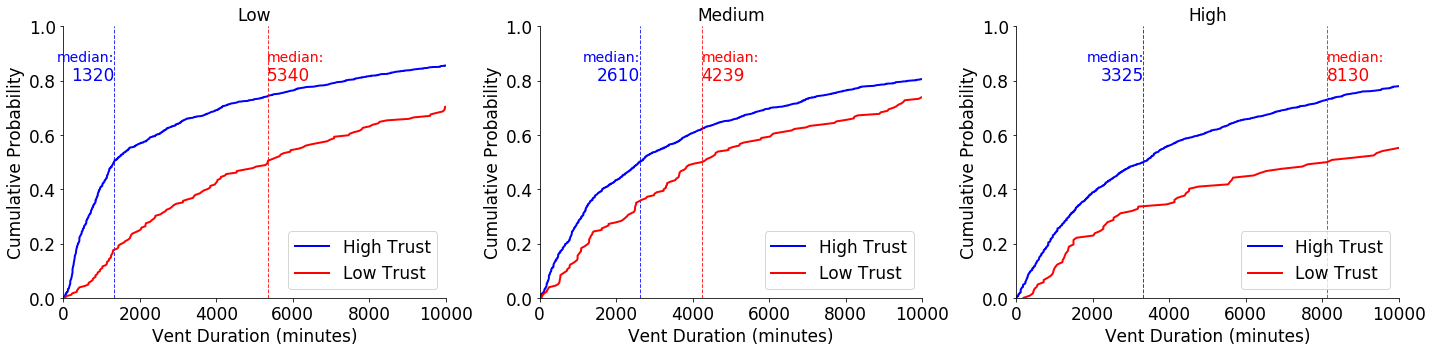

vaso
	vaso low
		High Trust 1449
		Low Trust 130
vaso low
	trust:    1449 1315.0
	mistrust: 130 2150.0
	p-value: 0.00012863680369469937
	vaso medium
		High Trust 1443
		Low Trust 152
vaso medium
	trust:    1443 1720.0
	mistrust: 152 2415.0
	p-value: 0.010040908554421675
	vaso high
		High Trust 1297
		Low Trust 139
vaso high
	trust:    1297 2238.0
	mistrust: 139 2715.0
	p-value: 0.004259737116212648


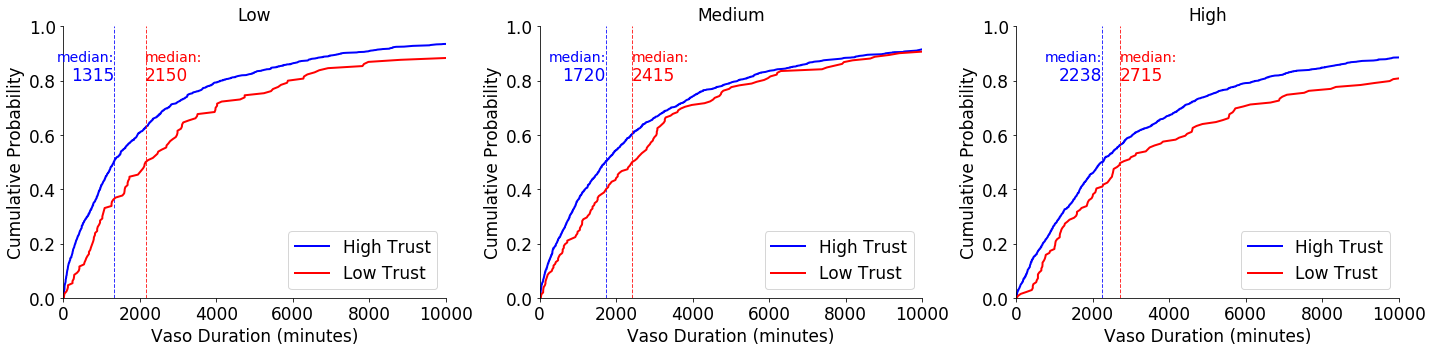

In [36]:
# Mistrust scores
print time.strftime("%Y-%m-%d %H:%M:%s")
import cPickle as pickle

#mistrust_str = 'mistrust_noncompliant'
mistrust_str = 'mistrust_autopsy'
#mistrust_str = 'neg_sentiment'

with open('../data/%s.pkl' % mistrust_str, 'rb') as f:
    trust_scores = pickle.load(f)
print time.strftime("%Y-%m-%d %H:%M:%s")


%matplotlib inline

import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu


# Put each treatment into the dictionary
T = {}
for vaso,vaso_quantity in vaso_quantities.items(): 
    # Get size of b/w cohorts
    vaso_white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(trust_scores.keys()) & set(vaso_quantity.keys())
    vaso_black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(trust_scores.keys()) & set(vaso_quantity.keys())

    # Stratify into high/low trust
    vaso_cohort = (vaso_white_ids | vaso_black_ids)  & set(vaso_quantity.keys())
    vaso_cohort_ids = sorted([(hadm_id,trust_scores[hadm_id]) for hadm_id in vaso_cohort], key=lambda t:t[1])
    vaso_trust_ids    = [hadm_id for hadm_id,score in vaso_cohort_ids[:len(vaso_white_ids) ]]
    vaso_mistrust_ids = [hadm_id for hadm_id,score in vaso_cohort_ids[ len(vaso_white_ids):]]

    trust_eol_vaso    = {hadm_id:vaso_quantity[hadm_id] for hadm_id in vaso_trust_ids    if hadm_id in vaso_quantity}
    mistrust_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in vaso_mistrust_ids if hadm_id in vaso_quantity}
    T[vaso] = {'Low Trust':mistrust_eol_vaso, 'High Trust':trust_eol_vaso}

# Get size of b/w cohorts
vent_white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(trust_scores.keys()) & set(vent_quantity.keys())
vent_black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(trust_scores.keys()) & set(vent_quantity.keys())

# Stratify into high/low trust
vent_cohort = (vent_white_ids | vent_black_ids)
vent_cohort_ids = sorted([(hadm_id,trust_scores[hadm_id]) for hadm_id in vent_cohort], key=lambda t:t[1])
vent_trust_ids    = [hadm_id for hadm_id,score in vent_cohort_ids[:len(vent_white_ids) ]]
vent_mistrust_ids = [hadm_id for hadm_id,score in vent_cohort_ids[ len(vent_white_ids):]]

trust_eol_vent    = {hadm_id:vent_quantity[hadm_id] for hadm_id in vent_trust_ids   }
mistrust_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in vent_mistrust_ids}
T['vent'] =  {'Low Trust':mistrust_eol_vent, 'High Trust':trust_eol_vent}



import pylab as plt

def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)/2]

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

colors = ['#0000FF', '#FF0000']
for treatment in T.keys():
    i = 0
    
    fig = pl.figure(treatment)

    t_median = list_median(T[treatment]['High Trust'].values())
    m_median = list_median(T[treatment][ 'Low Trust'].values())
    larger_median = min(t_median, m_median)
        
    for demographic in ['High Trust', 'Low Trust']:
        vals = list(T[treatment][demographic].values())
        #print(len(vals))
        #print (np.sort(vals)[int(len(vals)/2)])
        plt.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
        plt.xlim((0,10000))
        plt.ylim((0,1.0))

        median = np.sort(vals)[int(len(vals)/2)]
        plt.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
        if median == larger_median:
            p = 10
            h = 'right'
        else:
            p = -10
            h = 'left'
        #h = 'center'
        plt.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
        plt.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        i += 1

    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    #ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    #ax.spines["left"].set_visible(False)    
    plt.yticks(fontsize=17)    
    plt.xticks(fontsize=17) 

    plt.legend(loc=4, fontsize=17)
    plt.ylabel("Cumulative Probability", fontsize=17)
    plt.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

    plt.tight_layout()
    plt.savefig('../images/chapter5/%s_mimic_%s.png' % (mistrust_str,treatment))

    p1 = list(T[treatment]['High Trust'].values())
    p2 = list(T[treatment][ 'Low Trust'].values())
    w = mannwhitneyu(p1, p2)
    print mistrust_str
    print treatment
    print '\ttrust:   ', len(p1), t_median
    print '\tmistrust:', len(p2), m_median
    print '\tp-value:', w.pvalue
    
    plt.show()
    
    
    
treatment_severity_populations = {treatment:[] for treatment in T.keys()}
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            severity = severities[hadm_id]
            treatment_severity_populations[treatment].append(severity)

treatment_severity_thresholds = {}
for treatment,scores in treatment_severity_populations.items():
    vals = sorted(scores)
    n = len(vals)
    print treatment, vals[n/3], vals[2*n/3], len(vals[:n/3]), len(vals[n/3:2*n/3]), len(vals[2*n/3:])
    treatment_severity_thresholds[treatment] = vals[n/3], vals[2*n/3]
    
    
    
    
import tqdm

# partition by treatment
T_risk = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            # acuity bin
            severity = severities[hadm_id]
            if severities[hadm_id] <= treatment_severity_thresholds[treatment][0]:
                acuity = 'low'
            elif severities[hadm_id] <= treatment_severity_thresholds[treatment][1]:
                acuity = 'medium'
            else:
                acuity = 'high'

            T_risk[treatment][acuity][race].append(amount)

for treatment,cohorts in T_risk.items():
    print treatment
    for severity in ['low', 'medium', 'high']:
        print '\t', severity
        cohort = cohorts[severity]
        for race,ids in cohort.items():
            print '\t\t', race, len(ids)
            
            

for treatment in T_risk.keys():
    #if 'vaso' not in treatment: continue
    print treatment
    fig = pl.figure(treatment, (20,5))

    for i,severity in enumerate(['low','medium','high']):
        #fig = pl.figure('-'.join([treatment,severity]))
        ind = 131 + i
        ax = fig.add_subplot(ind)
                
        print '\t', treatment, severity

        t_median = list_median(T_risk[treatment][severity]['High Trust'])
        m_median = list_median(T_risk[treatment][severity][ 'Low Trust'])
        larger_median = min(t_median, m_median)
        
        for j,demographic in enumerate(['High Trust', 'Low Trust']):
            vals = list(T_risk[treatment][severity][demographic])
            #print(len(vals))
            #print (np.sort(vals)[int(len(vals)/2)])
            ax.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[j], label = demographic, lw=2)
            pl.xlim((0,10000))
            pl.ylim((0,1.0))

            print '\t\t', demographic, len(vals)
            median = np.sort(vals)[int(len(vals)/2)]
            ax.axvline(x=median, linestyle="--", lw=1, color=colors[j], alpha=0.8) 
            if median == larger_median:
                p = 10
                h = 'right'
            else:
                p = -10
                h = 'left'
            #h = 'center'
            ax.text(x=median+p, y=0.87, horizontalalignment=h, s="median:", fontsize=14, color=colors[j])
            ax.text(x=median+p, y=0.8 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[j])

        #ax = pl.subplot(111)    
        ax.spines["top"].set_visible(False)    
        #ax.spines["bottom"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        #ax.spines["left"].set_visible(False)    
        pl.yticks(fontsize=17)    
        pl.xticks(fontsize=17) 

        pl.title(captialize(severity), fontsize=17)
        pl.legend(loc=4, fontsize=17)
        pl.ylabel("Cumulative Probability", fontsize=17)
        pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

        pl.tight_layout()

        p1 = list(T_risk[treatment][severity]['High Trust'])
        p2 = list(T_risk[treatment][severity][ 'Low Trust'])
        w = mannwhitneyu(p1, p2)
        print treatment, severity
        print '\ttrust:   ', len(p1), t_median
        print '\tmistrust:', len(p2), m_median
        print '\tp-value:', w.pvalue
    pl.savefig('../images/chapter5/%s_mimic_%s_severity.png' % (mistrust_str,treatment))
    pl.show()
    #break
    #exit()


2019-01-05 00:00:1546664405
2019-01-05 00:00:1546664405
neg_sentiment
vent
	trust:    4366 2490.0
	mistrust: 469 3300.0
	p-value: 0.00010796591714416475


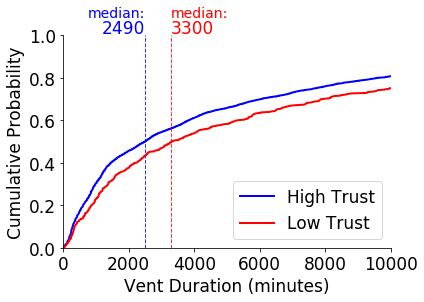

neg_sentiment
vaso
	trust:    4036 1770.0
	mistrust: 407 2086.0
	p-value: 0.0013127965310975305


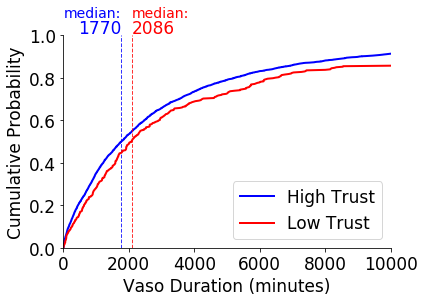

100%|██████████| 2/2 [00:00<00:00, 139.16it/s]

vent 35 43 1611 1612 1612
vaso 34 42 1481 1481 1481
vent
	low
		High Trust 1514
		Low Trust 155
	medium
		High Trust 1589
		Low Trust 167
	high
		High Trust 1263
		Low Trust 147
vaso
	low
		High Trust 1406
		Low Trust 136
	medium
		High Trust 1404
		Low Trust 135
	high
		High Trust 1226
		Low Trust 136
vent
	vent low
		High Trust 1514
		Low Trust 155
vent low
	trust:    1514 1425.0
	mistrust: 155 3060.0
	p-value: 0.003376338152533208
	vent medium
		High Trust 1589
		Low Trust 167


vent medium
	trust:    1589 2640.0
	mistrust: 167 3665.0
	p-value: 0.0014360165963261844
	vent high
		High Trust 1263
		Low Trust 147
vent high
	trust:    1263 3595.0
	mistrust: 147 3180.0
	p-value: 0.416891058619265


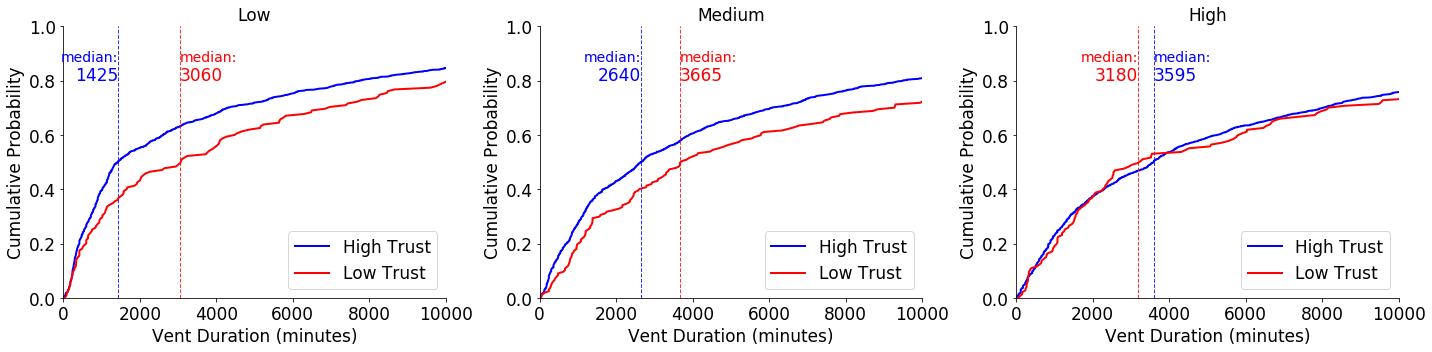

vaso
	vaso low
		High Trust 1406
		Low Trust 136
vaso low
	trust:    1406 1295.0
	mistrust: 136 1800.0
	p-value: 0.06168537144347039
	vaso medium
		High Trust 1404
		Low Trust 135
vaso medium
	trust:    1404 1764.0
	mistrust: 135 2101.0
	p-value: 0.0035768784525431795
	vaso high
		High Trust 1226
		Low Trust 136
vaso high
	trust:    1226 2325.0
	mistrust: 136 2460.0
	p-value: 0.18169387574197565


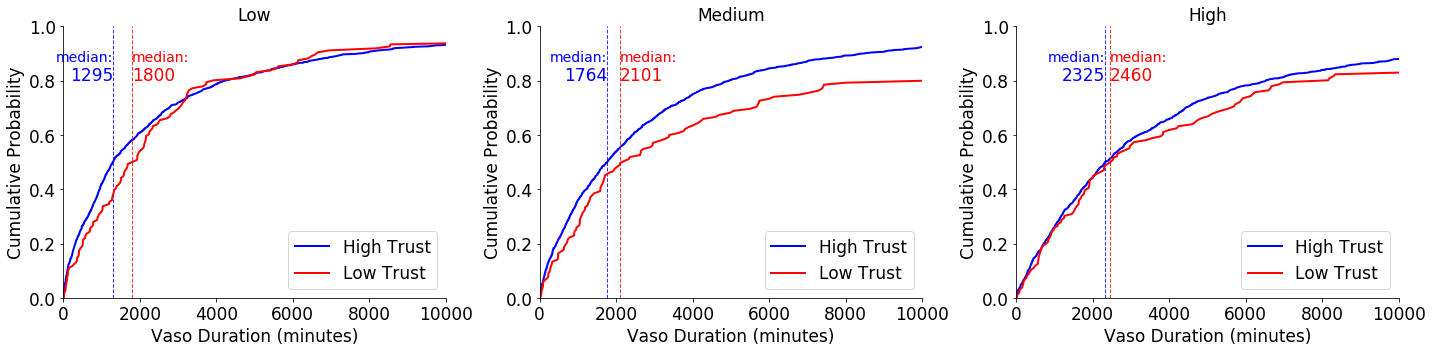

In [37]:
# Mistrust scores
print time.strftime("%Y-%m-%d %H:%M:%s")
import cPickle as pickle

#mistrust_str = 'mistrust_noncompliant'
#mistrust_str = 'mistrust_autopsy'
mistrust_str = 'neg_sentiment'

with open('../data/%s.pkl' % mistrust_str, 'rb') as f:
    trust_scores = pickle.load(f)
print time.strftime("%Y-%m-%d %H:%M:%s")


%matplotlib inline

import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu


# Put each treatment into the dictionary
T = {}
for vaso,vaso_quantity in vaso_quantities.items(): 
    # Get size of b/w cohorts
    vaso_white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(trust_scores.keys()) & set(vaso_quantity.keys())
    vaso_black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(trust_scores.keys()) & set(vaso_quantity.keys())

    # Stratify into high/low trust
    vaso_cohort = (vaso_white_ids | vaso_black_ids)  & set(vaso_quantity.keys())
    vaso_cohort_ids = sorted([(hadm_id,trust_scores[hadm_id]) for hadm_id in vaso_cohort], key=lambda t:t[1])
    vaso_trust_ids    = [hadm_id for hadm_id,score in vaso_cohort_ids[:len(vaso_white_ids) ]]
    vaso_mistrust_ids = [hadm_id for hadm_id,score in vaso_cohort_ids[ len(vaso_white_ids):]]

    trust_eol_vaso    = {hadm_id:vaso_quantity[hadm_id] for hadm_id in vaso_trust_ids    if hadm_id in vaso_quantity}
    mistrust_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in vaso_mistrust_ids if hadm_id in vaso_quantity}
    T[vaso] = {'Low Trust':mistrust_eol_vaso, 'High Trust':trust_eol_vaso}

# Get size of b/w cohorts
vent_white_ids = set(eol_cohort.loc[eol_cohort['race']=='White'].hadm_id.values) & set(trust_scores.keys()) & set(vent_quantity.keys())
vent_black_ids = set(eol_cohort.loc[eol_cohort['race']=='Black'].hadm_id.values) & set(trust_scores.keys()) & set(vent_quantity.keys())

# Stratify into high/low trust
vent_cohort = (vent_white_ids | vent_black_ids)
vent_cohort_ids = sorted([(hadm_id,trust_scores[hadm_id]) for hadm_id in vent_cohort], key=lambda t:t[1])
vent_trust_ids    = [hadm_id for hadm_id,score in vent_cohort_ids[:len(vent_white_ids) ]]
vent_mistrust_ids = [hadm_id for hadm_id,score in vent_cohort_ids[ len(vent_white_ids):]]

trust_eol_vent    = {hadm_id:vent_quantity[hadm_id] for hadm_id in vent_trust_ids   }
mistrust_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in vent_mistrust_ids}
T['vent'] =  {'Low Trust':mistrust_eol_vent, 'High Trust':trust_eol_vent}



import pylab as plt

def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)/2]

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

colors = ['#0000FF', '#FF0000']
for treatment in T.keys():
    i = 0
    
    fig = pl.figure(treatment)

    t_median = list_median(T[treatment]['High Trust'].values())
    m_median = list_median(T[treatment][ 'Low Trust'].values())
    larger_median = min(t_median, m_median)
        
    for demographic in ['High Trust', 'Low Trust']:
        vals = list(T[treatment][demographic].values())
        #print(len(vals))
        #print (np.sort(vals)[int(len(vals)/2)])
        plt.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
        plt.xlim((0,10000))
        plt.ylim((0,1.0))

        median = np.sort(vals)[int(len(vals)/2)]
        plt.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
        if median == larger_median:
            p = 10
            h = 'right'
        else:
            p = -10
            h = 'left'
        #h = 'center'
        plt.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
        plt.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        i += 1

    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    #ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    #ax.spines["left"].set_visible(False)    
    plt.yticks(fontsize=17)    
    plt.xticks(fontsize=17) 

    plt.legend(loc=4, fontsize=17)
    plt.ylabel("Cumulative Probability", fontsize=17)
    plt.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

    plt.tight_layout()
    plt.savefig('../images/chapter5/%s_mimic_%s.png' % (mistrust_str,treatment))

    p1 = list(T[treatment]['High Trust'].values())
    p2 = list(T[treatment][ 'Low Trust'].values())
    w = mannwhitneyu(p1, p2)
    print mistrust_str
    print treatment
    print '\ttrust:   ', len(p1), t_median
    print '\tmistrust:', len(p2), m_median
    print '\tp-value:', w.pvalue
    
    plt.show()
    
    
    
treatment_severity_populations = {treatment:[] for treatment in T.keys()}
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            severity = severities[hadm_id]
            treatment_severity_populations[treatment].append(severity)

treatment_severity_thresholds = {}
for treatment,scores in treatment_severity_populations.items():
    vals = sorted(scores)
    n = len(vals)
    print treatment, vals[n/3], vals[2*n/3], len(vals[:n/3]), len(vals[n/3:2*n/3]), len(vals[2*n/3:])
    treatment_severity_thresholds[treatment] = vals[n/3], vals[2*n/3]
    
    
    
    
import tqdm

# partition by treatment
T_risk = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            # acuity bin
            severity = severities[hadm_id]
            if severities[hadm_id] <= treatment_severity_thresholds[treatment][0]:
                acuity = 'low'
            elif severities[hadm_id] <= treatment_severity_thresholds[treatment][1]:
                acuity = 'medium'
            else:
                acuity = 'high'

            T_risk[treatment][acuity][race].append(amount)

for treatment,cohorts in T_risk.items():
    print treatment
    for severity in ['low', 'medium', 'high']:
        print '\t', severity
        cohort = cohorts[severity]
        for race,ids in cohort.items():
            print '\t\t', race, len(ids)
            
            

for treatment in T_risk.keys():
    #if 'vaso' not in treatment: continue
    print treatment
    fig = pl.figure(treatment, (20,5))

    for i,severity in enumerate(['low','medium','high']):
        #fig = pl.figure('-'.join([treatment,severity]))
        ind = 131 + i
        ax = fig.add_subplot(ind)
                
        print '\t', treatment, severity

        t_median = list_median(T_risk[treatment][severity]['High Trust'])
        m_median = list_median(T_risk[treatment][severity][ 'Low Trust'])
        larger_median = min(t_median, m_median)
        
        for j,demographic in enumerate(['High Trust', 'Low Trust']):
            vals = list(T_risk[treatment][severity][demographic])
            #print(len(vals))
            #print (np.sort(vals)[int(len(vals)/2)])
            ax.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[j], label = demographic, lw=2)
            pl.xlim((0,10000))
            pl.ylim((0,1.0))

            print '\t\t', demographic, len(vals)
            median = np.sort(vals)[int(len(vals)/2)]
            ax.axvline(x=median, linestyle="--", lw=1, color=colors[j], alpha=0.8) 
            if median == larger_median:
                p = 10
                h = 'right'
            else:
                p = -10
                h = 'left'
            #h = 'center'
            ax.text(x=median+p, y=0.87, horizontalalignment=h, s="median:", fontsize=14, color=colors[j])
            ax.text(x=median+p, y=0.8 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[j])

        #ax = pl.subplot(111)    
        ax.spines["top"].set_visible(False)    
        #ax.spines["bottom"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        #ax.spines["left"].set_visible(False)    
        pl.yticks(fontsize=17)    
        pl.xticks(fontsize=17) 

        pl.title(captialize(severity), fontsize=17)
        pl.legend(loc=4, fontsize=17)
        pl.ylabel("Cumulative Probability", fontsize=17)
        pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

        pl.tight_layout()

        p1 = list(T_risk[treatment][severity]['High Trust'])
        p2 = list(T_risk[treatment][severity][ 'Low Trust'])
        w = mannwhitneyu(p1, p2)
        print treatment, severity
        print '\ttrust:   ', len(p1), t_median
        print '\tmistrust:', len(p2), m_median
        print '\tp-value:', w.pvalue
    pl.savefig('../images/chapter5/%s_mimic_%s_severity.png' % (mistrust_str,treatment))
    pl.show()
    #break
    #exit()
